# AI Practical Assessment (JRP)

Author: Amir Fawwaz

Affliation: HT Consulting (Asia) Sdn. Bhd., Kelana Jaya, Malaysia

Published: 29 July 2024

## Question

Using alexnet as model, train suitable classifier and later compare with Support Vector Machine (SVM). Training shall be done using the following dataset:

- [cifar100](https://keras.io/api/datasets/cifar100/)
- [fruit-data](https://1drv.ms/f/s!ArxRwcm_oQh9gZZ6RKD8azw49Fbrzw?e=zbotuC)
- [potato-data](https://1drv.ms/f/s!ArxRwcm_oQh9gZZ6RKD8azw49Fbrzw?e=zbotuC)

Final evaluation will be perform using usualy confusion matrix.

### Potato Plant Diseases Classification with AlexNET

Same like before, we standardize all image at fixed resolution of `256 x 256`

In [1]:
!pip install scikit-learn-intelex

In [1]:
# Import Libraries
import tensorflow as tf
from sklearn.svm import SVC
import sklearn
from sklearnex import patch_sklearn 
patch_sklearn()

# Helper libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import shutil
from pathlib import Path

print('The tensorflow version is {}.'.format(tf.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


The tensorflow version is 2.10.1.
The scikit-learn version is 1.5.1.


In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

upload dataset and unzip (e.g. do this once only)

In [4]:
# !mkdir "/content/gdrive/My Drive/fruit"
# !unzip -q "/content/gdrive/My Drive/fruit.zip" -d "/content/gdrive/My Drive/fruit"

Images in each folder(class) in around 80-100 each. To split dataset, we manually create 3 folder "train","validation" and "test" following 80%-10%-10% splitting.

In [2]:
data_path = Path("potatos/PlantVillage/PlantVillage")
train_val_dir = Path('train_dataset')
test_dir = Path('test_dataset')

# Create temporary directories for train and test data
os.makedirs(train_val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

classes = os.listdir(data_path)

# Split data into train and test
train_split = 0.7
test_split = 0.15

for class_name in classes:
    class_dir = data_path / class_name
    images = list(class_dir.iterdir())
    np.random.shuffle(images)

    test_count = int(len(images) * test_split)

    train_val_images = images[:-test_count]
    test_images = images[-test_count:]

    os.makedirs(train_val_dir / class_name, exist_ok=True)
    os.makedirs(test_dir / class_name, exist_ok=True)

    for img in train_val_images:
        shutil.copy(img, train_val_dir / class_name)
    for img in test_images:
        shutil.copy(img, test_dir / class_name)

In [3]:
# Set the parameters for loading the dataset
batch_size = 32
img_height = 256
img_width = 256
validation_split = 0.2
seed_train_validation = 443

# Create the datasets
data_train = tf.keras.utils.image_dataset_from_directory(
    train_val_dir,
    shuffle= True,
    image_size= (img_width, img_height),
    batch_size = batch_size,
    label_mode ='categorical',
    seed = seed_train_validation,
    subset="training",
    validation_split=validation_split
)

data_val = tf.keras.utils.image_dataset_from_directory(
    train_val_dir,
    image_size=(img_width,img_height),
    batch_size=batch_size,
    shuffle=False,
    label_mode ='categorical',
    seed = seed_train_validation,
    subset="validation",
    validation_split=validation_split
)

data_test = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_width,img_height),
    batch_size=batch_size,
    shuffle=False,
    label_mode ='categorical',
    validation_split=False
)

Found 2146 files belonging to 3 classes.
Using 1717 files for training.
Found 2146 files belonging to 3 classes.
Using 429 files for validation.
Found 815 files belonging to 3 classes.


In [4]:
class_list = data_train.class_names
len(class_list)

3

From data splitting we can see that we have 36 image categories/classes.

## Visualize the data

Here are the 9 images (from 3rd batch) in the validation dataset.

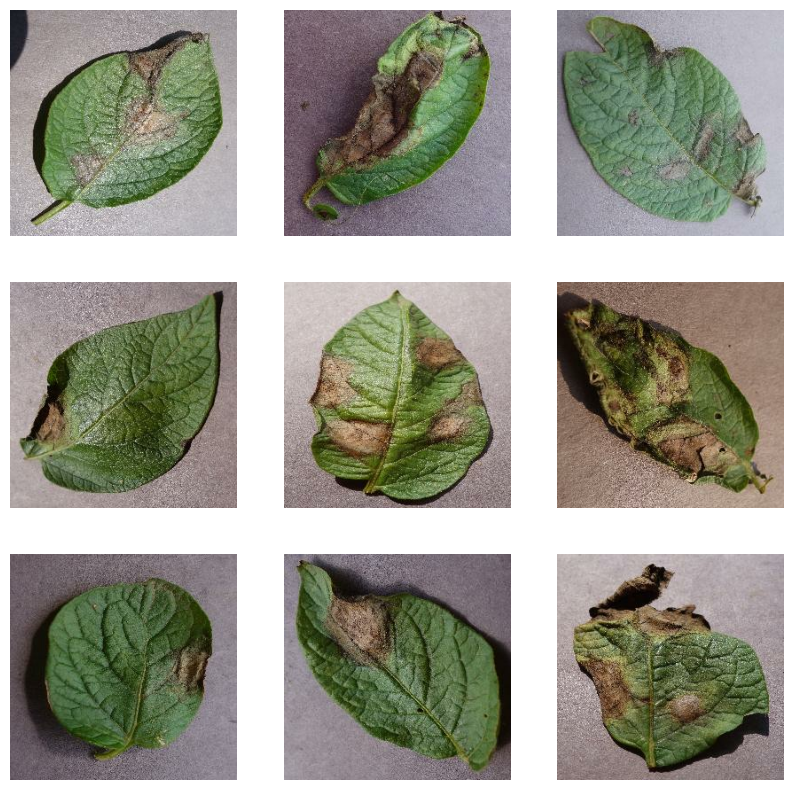

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in data_val.take(3):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.axis("off")

In [6]:
# define alexnet model
def my_alexnet(input_shape, num_classes):
    """ model is written in functional API way"""
    inputs = tf.keras.layers.Input(shape=input_shape, name = 'input')

    # Rescaling layers
    x = tf.keras.layers.Rescaling(1./255)(inputs)

    # First Convolutional Layer
    x = tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)

    # Second Convolutional Layer
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)

    # Third Convolutional Layer
    x = tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Fourth Convolutional Layer
    x = tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Fifth Convolutional Layer
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
    
    # Flatten the output for dense layers
    x = tf.keras.layers.Flatten()(x)
    
    # Fully Connected Layers
    x = tf.keras.layers.Dense(4096, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(4096, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    # Output Layer  
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
        
    outputs = tf.keras.layers.Dense(units, activation=activation)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="alexnet")
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
        
    return model

In [7]:
# Create the model & display model "stack"
model = my_alexnet(input_shape=(img_width, img_height) + (3,), num_classes=len(class_list))
model.summary()

Model: "alexnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 256)       6146

In [8]:
class myCallback(tf.keras.callbacks.Callback):
    # Define the correct function signature for on_epoch_end
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.99: # @KEEP
            print("\nReached 99% accuracy so cancelling training!") 
            # Stop training once the above condition is met
            self.model.stop_training = True

Here, i implement simple callback so that we stop the training once it reach required `accuracy`. More reading can be found [here](https://www.tensorflow.org/guide/keras/writing_your_own_callbacks).

In [9]:
%time history = model.fit(data_train, epochs=150, validation_data=data_val, verbose = 0, callbacks=[myCallback()])


Reached 99% accuracy so cancelling training!
CPU times: total: 59.1 s
Wall time: 4min 13s


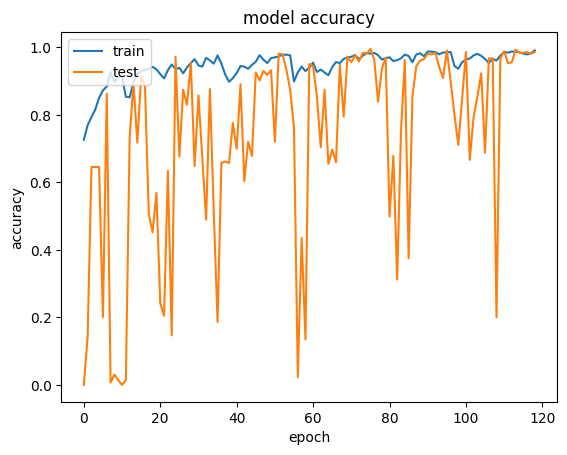

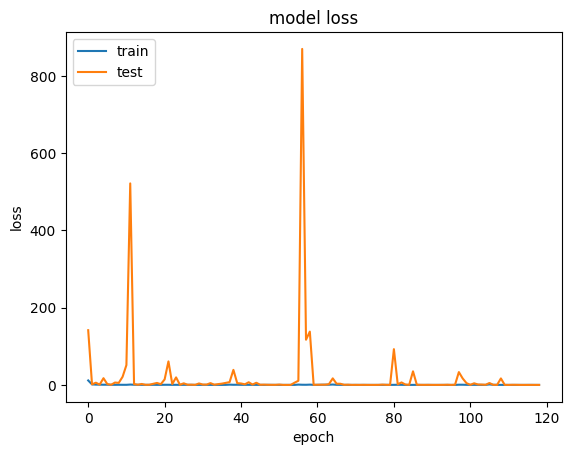

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
# Model evaluation
test_loss, test_acc = model.evaluate(data_test, verbose=2)

print(f"Test Accuracy: {test_acc*100:.2f}%")

26/26 - 1s - loss: 0.0430 - accuracy: 0.9791 - 728ms/epoch - 28ms/step
Test Accuracy: 97.91%


---

## _**Observation 1**_

1. From model accuracy & model loss plot above, we can observed that the trained model show signed of erratic overfitting from epoch 0 to 80. This is expected because "healty" data is smaller compared to "early blight" and "late blight". Small augmentation is recommended to "wash" away this erratic behaviour.
2. model training took 4min 13s
3. Model accuracy on _test data_ only give us 97.91% accuracy.

### Fruit Image Classification with Support Vector Machine

Now let's perform same classification using SVM from scikit package.

In [12]:
# Convert to NumPy arrays
def process_data(ds):
    x, y = [], []
    
    for images, labels in ds:
        x.append(images.numpy())
        y.append(labels.numpy())
    return np.concatenate(x), np.concatenate(y)

X_train, y_train = process_data(data_train)
X_val, y_val = process_data(data_val)
X_test, y_test = process_data(data_test)

In [13]:
X_train.shape,X_val.shape,X_test.shape

((1717, 256, 256, 3), (429, 256, 256, 3), (815, 256, 256, 3))

In [14]:
# Feature extraction (simple example: flatten images)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Convert categorical labels to numerical labels
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)
y_test = np.argmax(y_test, axis=1)

Since i'am running this training on personal laptop with Intel-i7-13700KF (32MB RAM), i will use all the available data. 

**Note**: on google collab, you need to sampling data into smaller part due to 12GB RAM limitation.

In [15]:
# Train SVM model
print("Training SVM model...")
svm_model = SVC(kernel='rbf', C=1.0, random_state=42, verbose=True)
%time svm_model.fit(X_train_flat, y_train)

Training SVM model...
[LibSVM]CPU times: total: 4min 17s
Wall time: 2min 39s


SVC(random_state=42, verbose=True)

In [16]:
# Test the model
print("Testing the model...")
%time test_predictions = svm_model.predict(X_test_flat)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Testing the model...
CPU times: total: 3min 19s
Wall time: 6min 32s
Test Accuracy: 96.69%


## Final Remark

We have compare 2 type of algorithm/approach to classify 36 categories of images data of fruits. AlexNet model evaluation from _test data_ gives 97.91% accuracy and SVM gives 96.69%. Another things to remark is training time for both Alexnet compared to SVM. 

## Marking Note

Total Mark  = [15 marks]

Estimated time = 45 - 60 minutes

Breakdown:
- format: [1 marks]
- Load Data: [2 marks]
- EDA: [1 marks]*
- Model/Algorithm: [1 marks]
- Successful training: [1 marks]
- Model Evaluation: [5 marks]
- Conclusion/Recommendation: [5 marks]

$^*$optional